In [1]:
import os
import datetime as dt
import sys
import pandas as pd
import numpy as np
import errno

import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

In [82]:
def printColumnInfo(df):
    for c in df.columns:
        print(df[c].dtype,c,df[c].iloc[11000])

def replaceNil(df):
    newdf = df.replace("-", 0, regex = True)
    return newdf

def plotgraph(mydf, X, Y, title):
    mydf.plot(x=X, y=Y, style='o')
    plt.title(title)
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.show()

def plotByIssuer(mydf, X, Y, issuer):
    mydf = mydf[(mydf['Issuer'] ==issuer)]
    mydf.plot(x=X, y=Y, style='o')
    plt.title(issuer)
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.show()
    
def plotVs(mydf, X, Y, iss1, iss2 ):
    mydf1 = mydf[(mydf['Issuer'] ==iss1)]
    mydf2 = mydf[(mydf['Issuer'] ==iss2)]
    x1 = mydf1[X]
    x2 = mydf2[X]
    y1 = mydf1[Y]
    y2 = mydf2[Y]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    axes[0].scatter(x1, y1)
    axes[0].set_title(iss1)
    axes[0].set_xlabel(X)
    axes[0].set_ylabel(Y)
    axes[1].scatter(x2, y2)
    axes[1].set_title(iss2)
    axes[1].set_xlabel(X)
    axes[1].set_ylabel(Y)
    fig.tight_layout()
    
    
def plotMoM(mydf, X, Y, M1, M2, iss=None ):
    if iss ==None:
        mydf1 = mydf[(mydf['TradeDate'].str.startswith(M1))]
        mydf2 = mydf[(mydf['TradeDate'].str.startswith(M2))]
        issuer = ""
    else:
        mydf1 = mydf[(mydf['Issuer'] ==iss) & (mydf['TradeDate'].str.startswith(M1))]
        mydf2 = mydf[(mydf['Issuer'] ==iss) & (mydf['TradeDate'].str.startswith(M2))]
        issuer = iss
    #print(mydf)
    x1 = mydf1[X]
    x2 = mydf2[X]
    y1 = mydf1[Y]
    y2 = mydf2[Y]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    axes[0].scatter(x1, y1)
    axes[0].set_title(issuer + " " + M1 )
    axes[0].set_xlabel(X)
    axes[0].set_ylabel(Y)
    axes[1].scatter(x2, y2)
    axes[1].set_title(issuer + " " + M2)
    axes[1].set_xlabel(X)
    axes[1].set_ylabel(Y)
    fig.tight_layout()

In [61]:
def addPremSold(df):
    mydf = df
    mydf['QtyBot'] = replaceNil(mydf['QtyBot'])
    mydf['QtySold'] = replaceNil(mydf['QtySold'])
    mydf['BotPx']= replaceNil(mydf['BotPx'])
    mydf['SoldPx']= replaceNil(mydf['SoldPx'])
    mydf['TO']= replaceNil(mydf['TO'])
    mydf['TO']=mydf['TO'].astype('int32')
    mydf['QtyBot']=mydf['QtyBot'].astype('int32')
    mydf['QtySold']=mydf['QtySold'].astype('int32')
    mydf['BotPx']=mydf['BotPx'].astype('float32')
    mydf['SoldPx']=mydf['SoldPx'].astype('float32')
    mydf['NetSold']=mydf['QtyBot'] + mydf['QtySold']
    #-ive premSold for boughtback
    mydf['PremSold'] = np.where(mydf['NetSold']>0,-1 * mydf['BotPx'] * mydf ['NetSold'], mydf['SoldPx'] * mydf['NetSold'])
    mydf['myKey'] = mydf['Underlying'] + '_' + mydf['Call/Put']
    #print(mydf)
    return mydf

In [64]:
#define file names and path
wrntpath = "D:\\Qilin\\HKEx\\WRNT\\"
cbbcpath = "D:\\Qilin\\HKEx\\CBBC\\"

wrntFileCol = ['Code','Name','TradeDate','QtyBot', 'BotPx','QtySold','SoldPx','OI','%OI','IssueSize','Delta','IV','FX',
           'High','Low','CLose','Volume','TO','Issuer','Underlying','Call/Put','Type','ListingDate',
           'LastTradingDate','Maturity','Strike_FX', 'Strike', 'CR', 'DelistDate']
cbbcFileCol = ['Code','Name','TradeDate','QtyBot', 'BotPx','QtySold','SoldPx','OI','%OI','IssueSize','FX',
           'High','Low','CLose','Volume','TO','Issuer','Underlying','Call/Put','Type','Cat','ListingDate',
           'LastTradingDate','Maturity','MCE','Strike_FX', 'Strike','KO', 'CR', 'DelistDate']

wrntAnalytic = ['myKey','Code','TradeDate','%OI','TO','Issuer','Underlying','Call/Put','Maturity','Strike','CR',
                'NetSold','PremSold']

cbbcAnalytic = ['myKey','Code','TradeDate','%OI','TO','Issuer','Underlying','Call/Put','Maturity','Strike','CR',
                'NetSold','PremSold']
#define file names
year = '2020'
wrntpath = wrntpath + year + "\\"
cbbcpath = cbbcpath + year + "\\"
wrntdf = pd.DataFrame(columns=wrntFileCol)
#for month in range (1,13):
#test with 2 months first
for month in range (1,7):
    month_string = '{:02d}'.format(month)
    filename = 'DW' + month_string +'.csv'
    location = os.path.abspath(wrntpath + filename)
    df_temp = pd.read_csv (location, sep='\t', header = 0, encoding = 'UTF-16 LE')
    df_temp.columns = wrntFileCol
    if (wrntdf.shape[0]==0):
        wrntdf = df_temp
        print(location + " loaded")
    else:
        wrntdf = wrntdf.append(df_temp)
        print(location + " appended")
cbbcdf = pd.DataFrame(columns=cbbcFileCol)
for month in range (1,8):
    month_string = '{:02d}'.format(month)
    filename = 'CBBC' + month_string +'.csv'
    location = os.path.abspath(cbbcpath + filename)
    df_temp = pd.read_csv (location, sep='\t', header = 0, encoding = 'UTF-16 LE')
    df_temp.columns = cbbcFileCol
    if (cbbcdf.shape[0]==0):
        cbbcdf = df_temp
        print(location + " loaded")
    else:
        cbbcdf = cbbcdf.append(df_temp)
        print(location + " appended")
wrntdf = addPremSold(wrntdf)
cbbcdf = addPremSold(cbbcdf)

D:\Qilin\HKEx\WRNT\2020\DW01.csv loaded
D:\Qilin\HKEx\WRNT\2020\DW02.csv appended
D:\Qilin\HKEx\WRNT\2020\DW03.csv appended
D:\Qilin\HKEx\WRNT\2020\DW04.csv appended
D:\Qilin\HKEx\WRNT\2020\DW05.csv appended
D:\Qilin\HKEx\WRNT\2020\DW06.csv appended
D:\Qilin\HKEx\CBBC\2020\CBBC01.csv loaded
D:\Qilin\HKEx\CBBC\2020\CBBC02.csv appended
D:\Qilin\HKEx\CBBC\2020\CBBC03.csv appended
D:\Qilin\HKEx\CBBC\2020\CBBC04.csv appended
D:\Qilin\HKEx\CBBC\2020\CBBC05.csv appended
D:\Qilin\HKEx\CBBC\2020\CBBC06.csv appended
D:\Qilin\HKEx\CBBC\2020\CBBC07.csv appended


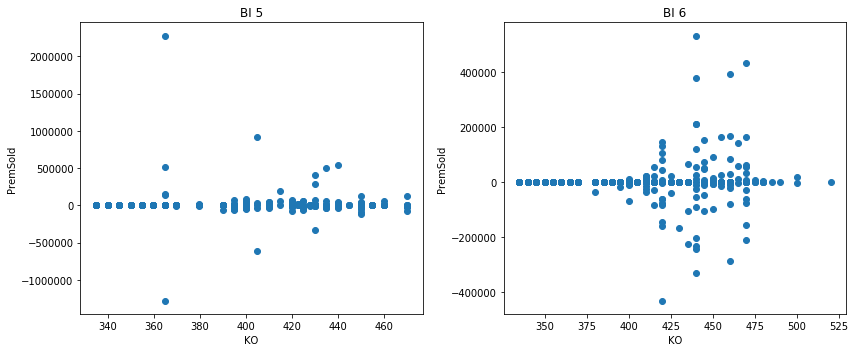

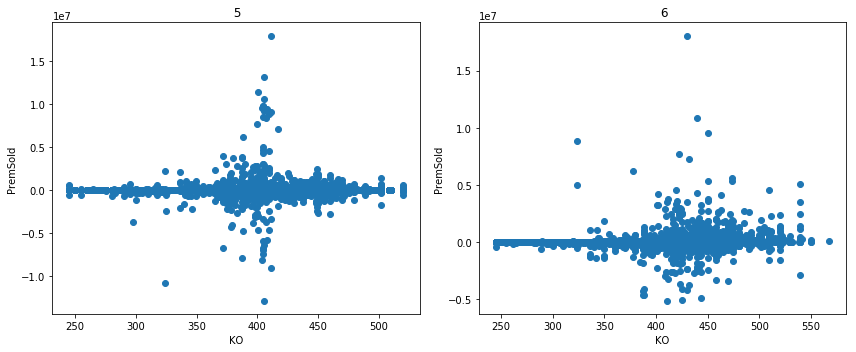

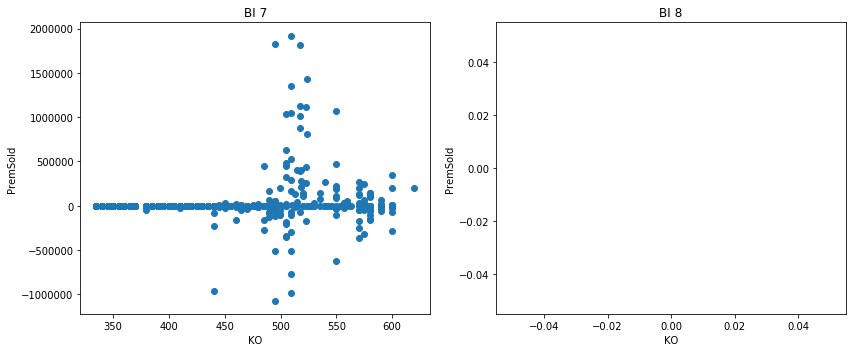

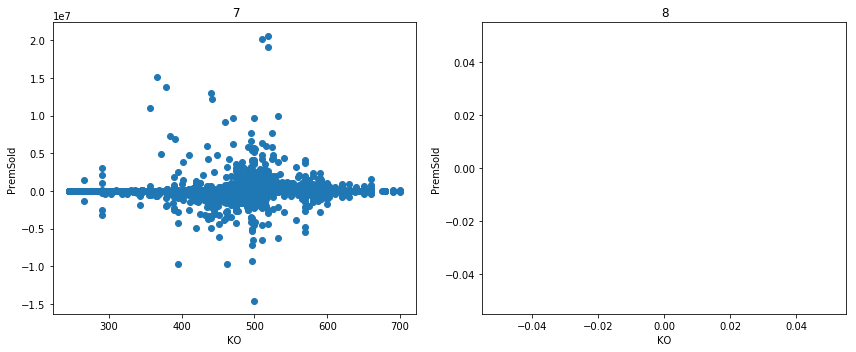

In [89]:
mydf = cbbcdf
X = 'KO'
Y = 'PremSold'
issuer = "BI"
plotdf = mydf[(mydf['Underlying'] =='700')]
plotMoM(plotdf, X, Y, '5', '6', issuer)
plotMoM(plotdf, X, Y, '5', '6')
plotMoM(plotdf, X, Y, '7', '8', issuer)
plotMoM(plotdf, X, Y, '7', '8')
#plotMoM(plotdf, 'TO','PremSold','CS', '6', '7')
#plotMoM(plotdf, 'TO','PremSold','UB', '6', '7')
#plotVs(plotdf, 'TO','PremSold','BI', 'HT')
#plotVs(plotdf, 'TO','PremSold','GS', 'BP')
#plotVs(plotdf, 'TO','PremSold','JP', 'CS')
#plotVs(plotdf, 'TO','PremSold','UB', 'SG')
#plotVs(plotdf, 'TO','PremSold','CT', 'MS')
#plotByIssuer(mydf, 'TO','PremSold','BI')

#mydf.groupby(['TradeDate','myKey']).sum()['PremSold'].astype('int32')
#mydf = mydf[(mydf['Underlying'] =='700') & (mydf['Call/Put'].str.startswith('C'))]
#outputdf = mydf.groupby(['TradeDate','myKey'])['PremSold', 'TO'].agg('sum').astype('int64')

In [98]:
mydf = cbbcdf
#X = 'KO'
#Y = 'PremSold'
modeldf = mydf[(mydf['Underlying'] =='700')]
X = modeldf['TO'].values.reshape(-1,1)
y = modeldf['PremSold'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

[-13666.16403762]
[[0.02572901]]


In [99]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,0.000000e+00,-13666.164038
1,0.000000e+00,-13666.164038
2,0.000000e+00,-13666.164038
3,-1.053945e+04,-9813.244599
4,-0.000000e+00,-6755.351610
5,0.000000e+00,-13666.164038
6,4.062323e+04,58818.146830
7,-0.000000e+00,12540.120394
8,9.050000e+02,-13452.484599
9,0.000000e+00,-13666.164038


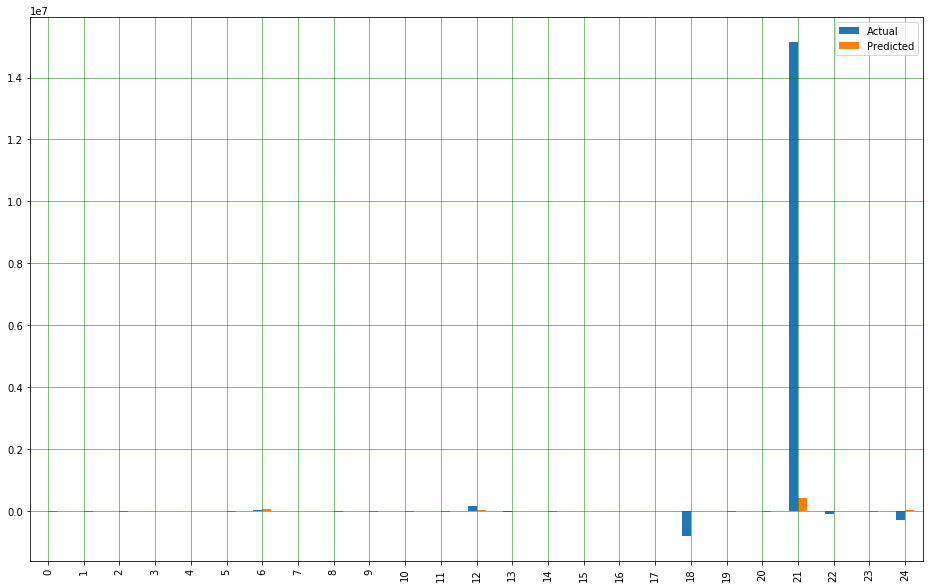

In [100]:
df1 = df.head(25)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

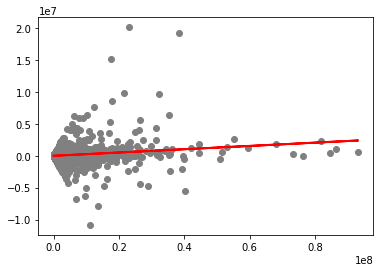

In [101]:
plt.scatter(X_test, y_test,  color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

In [102]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 105225.46099367403
Mean Squared Error: 244685255319.5577
Root Mean Squared Error: 494656.7045128952


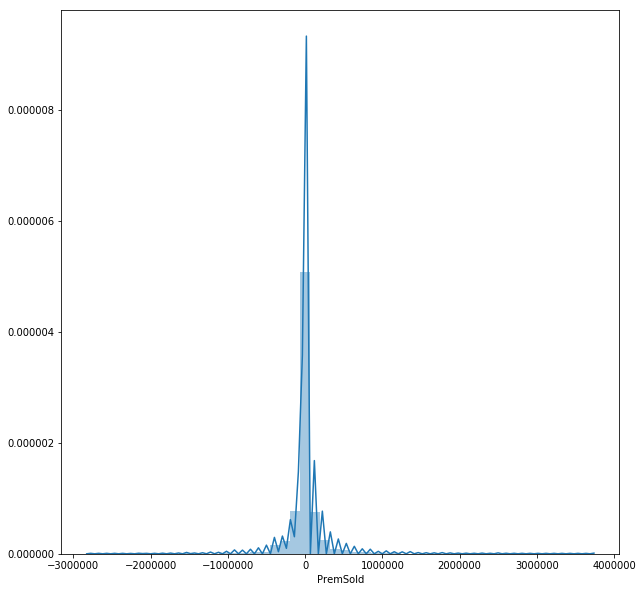

In [28]:
plt.figure(figsize=(10,10))
plt.tight_layout()
seabornInstance.distplot(newdf['PremSold'])

In [ ]:
'''
source website
https://towardsdatascience.com/machine-learning-with-python-classification-complete-tutorial-d2c99dc524ec
'''
## for data
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for explainer
from lime import lime_tabular

In [ ]:
dtf = pd.read_csv('data_titanic.csv')
dtf.head()

In [ ]:
'''
Recognize whether a column is numerical or categorical.
'''
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"

In [ ]:
dic_cols = {col:utils_recognize_type(dtf, col, max_cat=max_cat) for col in dtf.columns}
heatmap = dtf.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")

In [ ]:
dtf = dtf.set_index("PassengerId")
dtf = dtf.rename(columns={"Survived":"Y"})

In [ ]:
y = "Y"
ax = dtf[y].value_counts().sort_values().plot(kind="barh")
totals= []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20, 
     str(round((i.get_width()/total)*100, 2))+'%', 
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(y, fontsize=20)
plt.show()